## ERDDAP with erddapy example for ITAE Prawler - 2017/2019 C2 (Chlorphyll+other eco)

***requires python 3.6*** for passing time information (pandas datetime to timestamp doesn't appear to work in 2.7)

In [1]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2020-04-06 14:56:56.353367


### connecting and basic information

In [15]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

In [93]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='ck and prawler'))

In [94]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 3 tabledap, 0 griddap, and 0 wms endpoints.'

In [95]:
prawlers = df['Dataset ID'].values
print(prawlers)

['erddap_17ckitaem2a_prawler' 'erddap_19CKitaepr2a_prawler'
 'erddap_17ckitaem2a_met']


In [96]:
variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in prawlers]
print(variables)

[['latitude', 'time', 'longitude', 'Oxy_Temperature', 'Salinity', 'Turbidity', 'SigmaT', 'Oxy_Conc', 'Temperature', 'depth', 'Chlorophyll', 'Oxy_Sat'], ['latitude', 'time', 'longitude', 'Salinity', 'depth', 'Chlorophyll'], ['air_temperature', 'latitude', 'relative_humidity', 'time', 'longitude', 'air_pressure', 'eastward_wind', 'wind_speed', 'northward_wind', 'wind_from_direction']]


### retrieving and plotting data

In [109]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='erddap_19CKitaepr2a_prawler'

d.variables =  [
 'profile_id',
 'Chlorophyll',
 'depth',
 'time',
]

d.constraints = {
    'time>=': '2017-01-01T00:00:00Z',
    'time<=': '2020-10-10T00:00:00Z',
}

In [110]:
d.get_download_url()

'http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/erddap_19CKitaepr2a_prawler.csv?profile_id,Chlorophyll,depth,time&time>=1483228800.0&time<=1602288000.0'

In [111]:
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.head()

,profile_id,Chlorophyll,depth (m)
time (UTC),,,
2019-08-18 22:17:24+00:00,1,0.2260,4.69
2019-08-18 22:17:32+00:00,1,0.2712,4.67
2019-08-18 22:17:40+00:00,1,0.2034,4.59
2019-08-18 22:17:48+00:00,1,0.2260,4.57
2019-08-18 22:17:56+00:00,1,0.2034,4.60


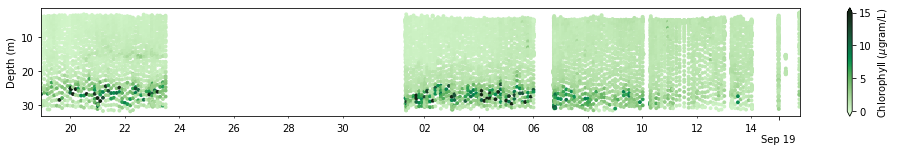

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import cmocean

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth (m)'], s=15, c=df['Chlorophyll'], marker='o', edgecolor='none', vmin=0, vmax=15, cmap=cmocean.cm.algae)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,2)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax.xaxis.set_tick_params(which='major', pad=15)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll ($\mu$gram/L)')
ax.set_ylabel('Depth (m)');

In [114]:
e = ERDDAP(server=server_url)
df_ck = pd.read_csv(e.get_search_url(response='csv', search_for='ckp2a_final'))

print(df_ck['Dataset ID'].values)

['datasets_Mooring_16ckp2a_final' 'datasets_Mooring_17ckp2a_final'
 'datasets_Mooring_18ckp2a_final']


In [115]:
from requests.exceptions import HTTPError

dfs = {}
for dataset_id in df_ck['Dataset ID'].values:
    print(dataset_id)
    try:
        d = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        d.dataset_id=dataset_id
        
        d.variables = ['Chlorophyll_Fluorescence','depth','time']
    except HTTPError:
        print('Failed to generate url {}'.format(dataset_id))

    try:
        df_m = d.to_pandas(
                    index_col='time (UTC)',
                    parse_dates=True,
                    skiprows=(1,)  # units information can be dropped.
                    )
        df_m.sort_index(inplace=True)
        df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]
        
        #-9999 and 1e35 are missing values... but erddap doesn't catch the -9999 yet 
        #and some 1e35 are off a bit
        df_m['depth'][(df_m.depth == -9999)] = np.nan # only in pressure field
        dfs.update({dataset_id:df_m})
    except:
        pass


datasets_Mooring_16ckp2a_final
datasets_Mooring_17ckp2a_final
datasets_Mooring_18ckp2a_final


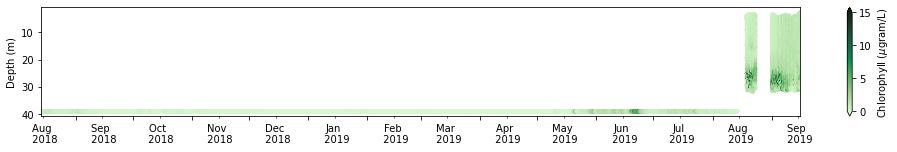

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import cmocean

df_s = dfs['datasets_Mooring_18ckp2a_final'][dfs['datasets_Mooring_18ckp2a_final'] <=1e34].dropna()

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['depth (m)'], s=15, c=df['Chlorophyll'], marker='o', edgecolor='none', vmin=0, vmax=15, cmap=cmocean.cm.algae)

cs = ax.scatter(df_s.index, df_s['depth'], s=15, c=df_s['Chlorophyll_Fluorescence'], marker='o', edgecolor='none', vmin=0, vmax=15, cmap=cmocean.cm.algae)

ax.invert_yaxis()
ax.set_xlim(df_s.index.min(), df.index.max())
ax.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_formatter(DateFormatter('%b \n %Y'))
ax.xaxis.set_major_formatter(DateFormatter(''))
ax.xaxis.set_tick_params(which='major', pad=15)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll ($\mu$gram/L)')
ax.set_ylabel('Depth (m)');

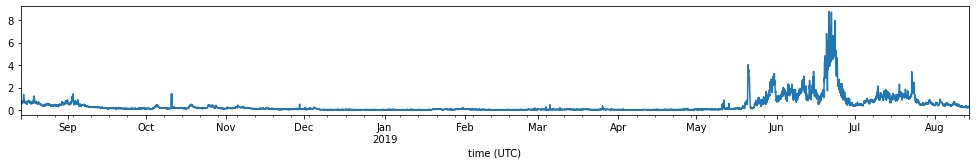

In [117]:
fig, ax = plt.subplots(figsize=(17, 2))
df_s['Chlorophyll_Fluorescence'].dropna().plot()